In [50]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import json

## PreProcessing

Converting audio files to frequency-binning features and saving them.

In [51]:
# Paths
DATA_ROOT = Path("/kaggle/input/birdclef-2025")
AUDIO_ROOT = DATA_ROOT / "train_audio"

# Spectrogram binning params
SAMPLE_RATE = 32000
N_FFT = 1024
HOP_LENGTH = 512
MAX_FREQ = 16000
BIN_SIZE = 5
NUM_BINS = MAX_FREQ // BIN_SIZE

def audio_to_binary_vector(path):
    y, sr = librosa.load(path, sr=SAMPLE_RATE)
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)

    idx = freqs <= MAX_FREQ
    S = S[idx, :]
    freqs = freqs[idx]

    energy = S.max(axis=1)
    threshold = np.percentile(energy, 85)

    binary_vec = np.zeros(NUM_BINS, dtype=int)
    for i, f in enumerate(freqs):
        bin_idx = int(f // BIN_SIZE)
        if energy[i] > threshold:
            binary_vec[bin_idx] = 1
    return binary_vec

# Top species from species_stats earlier
top_species = ["grekis", "compau", "trokin", "roahaw", "banana", "whtdov", "socfly1", "yeofly1", "bobfly1", "wbwwre1"]

output = []

for sp in top_species:
    folder = AUDIO_ROOT / sp
    files = sorted(folder.glob("*.ogg"))[:50]

    for f in files:
        try:
            vec = audio_to_binary_vector(f)
            output.append({
                "species": sp,
                "filename": f.name,
                "vector": vec.tolist()
            })
        except Exception as e:
            print(f"{f.name} — {e}")

# Save to file
df = pd.DataFrame(output)
df.to_json("/kaggle/working/bird_vectors_top10.json", orient="records", lines=True)
print("Saved", len(df), "samples.")


Saved 500 samples.


## Random Forest Classifier (Evaluation and Visualization)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import json

# Load vector dataset
with open("/kaggle/working/bird_vectors_top10.json") as f:
    lines = [json.loads(l) for l in f]

df = pd.DataFrame(lines)
species_list = df["species"].unique()

results = []

for sp in species_list:
    X = np.array(df["vector"].tolist())
    y = (df["species"] == sp).astype(int)

    if y.sum() < 5:
        print(f"Skipping {sp}: Not enough positives.")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        "species": sp,
        "positive_samples": int(y.sum()),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1_score": round(f1, 3)
    })

# Show leaderboard
leaderboard = pd.DataFrame(results).sort_values("f1_score", ascending=False)
print("Per-Bird Detector Leaderboard:")
print(leaderboard)


Per-Bird Detector Leaderboard:
   species  positive_samples  precision  recall  f1_score
4   banana                50      0.846   0.733     0.786
1   compau                50      0.909   0.667     0.769
2   trokin                50      0.562   0.600     0.581
5   whtdov                50      0.714   0.333     0.455
3   roahaw                50      1.000   0.267     0.421
6  socfly1                50      1.000   0.067     0.125
7  yeofly1                50      1.000   0.067     0.125
0   grekis                50      0.000   0.000     0.000
8  bobfly1                50      0.000   0.000     0.000
9  wbwwre1                50      0.000   0.000     0.000


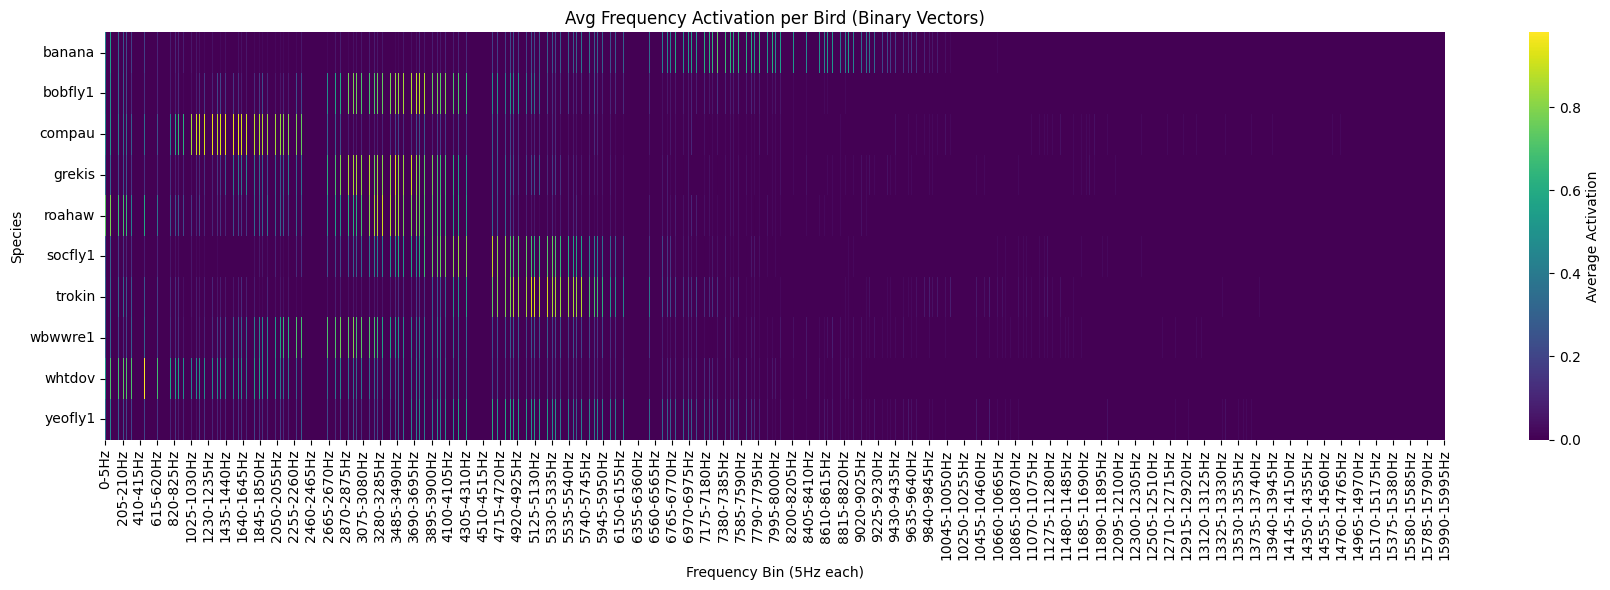

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prep vectors grouped by species
species_vectors = df.groupby("species")["vector"].apply(lambda x: np.mean(x.tolist(), axis=0))

# Convert to DataFrame
avg_df = pd.DataFrame(species_vectors.tolist(), index=species_vectors.index)
avg_df.columns = [f"{5*i}-{5*i+5}Hz" for i in range(avg_df.shape[1])]

# Plot as heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(avg_df, cmap="viridis", cbar_kws={'label': 'Average Activation'})
plt.title("Avg Frequency Activation per Bird (Binary Vectors)")
plt.xlabel("Frequency Bin (5Hz each)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()

In [54]:
import librosa
import numpy as np
import cv2

# Mel-spectrogram parameters
SAMPLE_RATE = 32000
N_MELS = 128
HOP_LENGTH = 512
DURATION = 5  # seconds
SAMPLES = SAMPLE_RATE * DURATION

def audio_to_logmelspec(path, resize_shape=(128, 256)):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)

    logmel = librosa.power_to_db(mel)

    # Normalize to 0–1
    logmel -= logmel.min()
    logmel /= logmel.max()

    # Resize to fixed shape (e.g. 128×256)
    logmel_resized = cv2.resize(logmel, resize_shape)
    return logmel_resized.astype(np.float32)


In [55]:
from pathlib import Path

AUDIO_ROOT = Path("/kaggle/input/birdclef-2025/train_audio")
banana_files = sorted(list((AUDIO_ROOT / "banana").glob("*.ogg")))
print("Available banana files:", banana_files[:5])


Available banana files: [PosixPath('/kaggle/input/birdclef-2025/train_audio/banana/XC112602.ogg'), PosixPath('/kaggle/input/birdclef-2025/train_audio/banana/XC113782.ogg'), PosixPath('/kaggle/input/birdclef-2025/train_audio/banana/XC115505.ogg'), PosixPath('/kaggle/input/birdclef-2025/train_audio/banana/XC116098.ogg'), PosixPath('/kaggle/input/birdclef-2025/train_audio/banana/XC116099.ogg')]


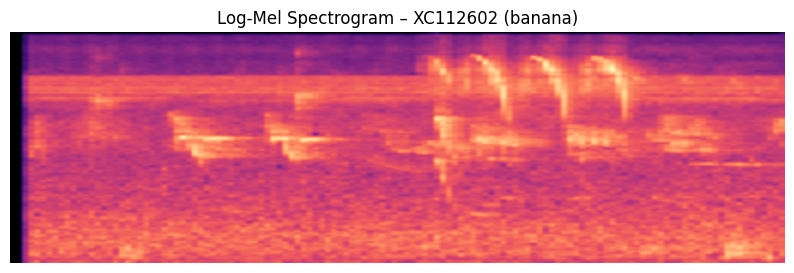

In [56]:
# Pick a real file
real_path = "/kaggle/input/birdclef-2025/train_audio/banana/XC112602.ogg"
spec = audio_to_logmelspec(real_path)

# Plot it
plt.figure(figsize=(10, 3))
plt.imshow(spec, origin="lower", aspect="auto", cmap="magma")
plt.title("Log-Mel Spectrogram – XC112602 (banana)")
plt.axis("off")
plt.show()

In [57]:
from sklearn.model_selection import train_test_split
import random

# Load banana + negatives
positive_files = list((AUDIO_ROOT / "banana").glob("*.ogg"))[:40]

# Sample negatives from any other class
other_species = [s for s in AUDIO_ROOT.iterdir() if s.name != "banana"]
negative_files = []
for s in random.sample(other_species, 3):  # pick 3 random species
    negative_files += list(s.glob("*.ogg"))[:15]

X, y = [], []

# banana = 1
for f in positive_files:
    try:
        X.append(audio_to_logmelspec(str(f)))
        y.append(1)
    except:
        continue

# others = 0
for f in negative_files:
    try:
        X.append(audio_to_logmelspec(str(f)))
        y.append(0)
    except:
        continue

# Prepare for CNN
X = np.array(X)[..., np.newaxis]  # (n, 128, 256, 1)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(128, 256, 1)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=8)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6504 - loss: 1.2938 - val_accuracy: 0.4706 - val_loss: 0.7469
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4768 - loss: 0.7385 - val_accuracy: 0.4706 - val_loss: 0.7084
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4914 - loss: 0.7036 - val_accuracy: 0.4706 - val_loss: 0.6930
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4806 - loss: 0.6829 - val_accuracy: 0.5294 - val_loss: 0.7048
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5725 - loss: 0.7348 - val_accuracy: 0.5294 - val_loss: 0.6902


In [59]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val).ravel()
y_pred_cls = (y_pred > 0.5).astype(int)

print(classification_report(y_val, y_pred_cls))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
from pathlib import Path
import pandas as pd
import numpy as np

# Paths
TEST_AUDIO_ROOT = Path("/kaggle/input/birdclef-2025/test_soundscapes")
SAMPLE_SUB_PATH = Path("/kaggle/input/birdclef-2025/sample_submission.csv")

# Load test files
test_files = sorted(TEST_AUDIO_ROOT.glob("*.ogg"))
print("Found", len(test_files), "test files")

# Predict banana probabilities
test_preds = []
for f in test_files:
    try:
        spec = audio_to_logmelspec(str(f))
        spec = spec[np.newaxis, ..., np.newaxis]  # shape = (1, 128, 256, 1)
        prob = model.predict(spec)[0][0]  # single probability
        test_preds.append((f.stem, prob))
    except Exception as e:
        print(f"Error on {f.name}: {e}")

# Prepare submission
sub_df = pd.read_csv(SAMPLE_SUB_PATH)
sub_df.iloc[:, 1:] = 0.0  # set all species to 0
for row_id, prob in test_preds:
    sub_df.loc[sub_df["row_id"] == row_id, "banana"] = prob

# Save
sub_df.to_csv("/kaggle/working/submission.csv", index=False)
print("CNN-based banana submission saved.")


Found 0 test files
CNN-based banana submission saved.


In [61]:
# Load test files
test_files = sorted(TEST_AUDIO_ROOT.glob("*.ogg"))

# Convert to binary vectors
binary_preds = []
for f in test_files:
    try:
        vec = audio_to_binary_vector(str(f))
        vec = np.array(vec).reshape(1, -1)
        prob = rf_model.predict_proba(vec)[0][1]  # positive class probability
        binary_preds.append((f.stem, prob))
    except Exception as e:
        print(f"Error: {f.name} → {e}")

# Format into sample_submission
sub_df = pd.read_csv(SAMPLE_SUB_PATH)
sub_df.iloc[:, 1:] = 0.0
for row_id, prob in binary_preds:
    sub_df.loc[sub_df["row_id"] == row_id, "banana"] = prob

# Save
sub_df.to_csv("/kaggle/working/banana_rf_submission.csv", index=False)
print("RF-based banana submission saved.")

RF-based banana submission saved.
